# 1 - PROBLEM DEFINITION

# 2 - IMPORTS

## 2.1 - Python Libraries

In [1]:
# General
import pandas as pd
import numpy as np
import seaborn as sns
import statistics

# Visualization
import matplotlib.pyplot as plt

# Validator
from scipy.stats import norm

# Data normalization
from sklearn.preprocessing import MinMaxScaler

# Data StandardScaler
from sklearn.preprocessing import StandardScaler

# Machine Learning Model
from sklearn.neighbors import KNeighborsClassifier

# Splitting data for training and testing the model
from sklearn.model_selection import train_test_split

# Metric accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# Model Verification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 

## 2.2 - Functions

### 2.2.1 - Categorical and Numerical

In [2]:
def get_categorical_data(data):
    return data.select_dtypes(exclude=['int64', 'float64'])

In [3]:
def get_numerical_data(data):
    return data.select_dtypes(include=['int64', 'float64'])

### 2.2.2 - Descriptive Info

In [4]:
def descriptive_info(data) -> pd.core.frame.DataFrame : 
    numerical_attributes = get_numerical_data(data)
    categorical_attributes = get_categorical_data(data)
    
    # Calculate mean and median for the numeric attributes
    df_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    df_median = pd.DataFrame(numerical_attributes.apply(np.median)).T
    
    # Calculate dispersion statistics: std, min, max, range, skew, kurtosis
    df_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    df_min = pd.DataFrame(numerical_attributes.apply(min)).T
    df_max = pd.DataFrame(numerical_attributes.apply(max)).T
    df_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    df_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    df_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T
    
    # Concatene the calculated statistics into a single DataFrame
    df_descriptive = pd.concat([df_min,
                               df_max,
                               df_range,
                               df_mean,
                               df_median,
                               df_std,
                               df_skew,
                               df_kurtosis]).T.reset_index()
    
    df_descriptive.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return df_descriptive

### 2.2.3 - Exploring Columns

In [5]:
def exploring_columns(data, columns):
    for col in columns:
        print('--------------------------')
        print(f'Series: {col}')
        print('--------------------------')
        print(f'{data[col].value_counts(dropna=False)}', end='\n\n')

### 2.2.4 - Plot Normal Distribution Comparison

In [6]:
def plot_normal_distribution_comparison(data, target='Feature 1'):
    plt.figure(figsize=(15, 15))

    num_rows = 3
    num_cols = 3

    for i, column in enumerate(data.drop(columns=target).columns):
        plt.subplot(num_rows, num_cols, i+1)
        plt.hist(data[column], bins=30, density=True, alpha=0.6, color='g')

        column_mean = np.mean(data[column])
        column_std = np.std(data[column])
        
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, column_mean, column_std)
        plt.plot(x, p, 'k', linewidth=2)
        
        plt.title(f'Normal Distribution Plot for {column}')
        plt.xlabel(f'{column}')
        
    plt.tight_layout()

    plt.show()

### 2.2.5 - Plot Triangle Correlation Heatmap

In [7]:
def plot_triangle_correlation_heatmap(data):
    corr = data.corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.set_theme(style='white')

    plt.figure(figsize=(16, 6))
    heatmap = sns.heatmap(corr,
                          mask=mask,
                          cmap='rocket_r',
                          annot=True,
                          fmt='.2f',
                          linewidths=.5)
    
    heatmap.set_title('Triangle Correlation Heatmap', pad=16)

    plt.show()

### 2.2.6 - Plot Coefficient Magnitude Comparison

In [8]:
def plot_coefficient_magnitude_comparison(data, features_to_compare):
    plt.figure(figsize=(10,6))

    markers = ['o', 's', '^', 'v', '<', '>', 'p', '*']

    for i, feature in enumerate(features_to_compare):
        marker = markers[i % len(markers)]
        plt.plot(data[feature], marker, label=feature)

    plt.legend(loc='best')
    plt.ylabel('Coefficient Magnitude')
    plt.xlabel('Coefficient Index')
    plt.title('Comparison of Coefficient Magnitudes for Features')
    plt.show()

### 2.2.7 - Plot Check Pairplot

In [9]:
def plot_check_pairplot(data, target):
    plt.figure(figsize=(16, 6))
    pairplot = sns.pairplot(data, 
                            hue=target,
                            palette='dark',
                            corner=True
                           )
    pairplot.add_legend()
    plt.show()

### 2.2.8 - Plot Feature Distributions by Target

In [10]:
def plot_feature_distributions_by_target(data, target):
    plt.figure(figsize=(15,15))
    num_rows = 3
    num_cols = 3
    for i, col in enumerate(data.drop(columns=target).columns):
        plt.subplot(num_rows, num_cols, i+1)
        sns.histplot(data=data, x=col, hue=target, multiple='stack', palette='dark')
        plt.title(f'{col} Distribution', fontsize=16)

    plt.tight_layout()
    plt.show()

### 2.2.9 - Find and Analyse Outliers

In [11]:
def find_and_analyze_outliers(data) -> pd.core.frame.DataFrame:
    numeric_attributes = get_numerical_data(data)

    Q1 = numeric_attributes.quantile(0.25)
    Q3 = numeric_attributes.quantile(0.75)
    IQR = Q3 - Q1

    inf_lim = Q1 - 1.5 * IQR
    sup_lim = Q3 + 1.5 * IQR

    outliers = ((numeric_attributes < inf_lim) | (numeric_attributes > sup_lim))
    
    outliers_count = outliers.sum()
    outliers_percentage = (outliers_count / len(numeric_attributes)) * 100 
    
    df_outliers = data[outliers.any(axis=1)]
    
    df_outliers_analyze = pd.DataFrame({
        'Outliers Count':outliers_count,
        'Outliers Percentage': outliers_percentage
    })
    
    df_outliers_analyze = df_outliers_analyze[df_outliers_analyze['Outliers Count'] > 0]
    
    df_outliers_analyze = df_outliers_analyze.sort_values(by='Outliers Count', ascending = False)
    
    return df_outliers, df_outliers_analyze

### 2.2.10 - Plot Boxplot

In [12]:
def plot_boxplot(data, features=None, target=None):
    plt.figure(figsize=(15, 10))
    
    if features is None:
        features = data.columns

    if target is None:
        target = data.columns[0]
    
    for i, feature in enumerate(features):
        plt.subplot(3, 5, i+1)
        
        sns.boxplot(y=feature, hue = target, data = data)
        
        plt.title(f'{feature} by {target}')
        plt.xlabel(target)
        plt.ylabel(feature)

    plt.tight_layout()

    plt.show()

### 2.2.11 - Categorical Distribution

In [13]:
def plot_categorical_distribution(data, target='Survived'):
    plt.figure(figsize=(15, 15))

    num_rows = 3
    num_cols = 3

    for i, column in enumerate(get_categorical_data(data).drop(columns='Name').columns):
        plt.subplot(num_rows, num_cols, i+1)
        sns.countplot(x=column, data=data, hue=target, palette='viridis')
        plt.title(f'Count Plot for {column}')

        
    plt.tight_layout()
    plt.show()


### 2.2.12 - Data Transform

In [14]:
def data_transform(data):
    # Separar o nome por título
    data['Title'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

    # Mapear o título para valores numéricos
    title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Dr': 4, 'Rev': 5, 'Col': 6, 'Major': 7, 'Mlle': 8, 'Ms': 9, 'Lady': 10, 'Sir': 11, 'Mme': 12, 'Countess': 13, 'Jonkheer': 14, 'Don': 15, 'Capt': 16, 'Dona': 17}
    data['Title'] = data['Title'].map(title_mapping)

    # Mapear o sexo para valores numéricos
    sex_mapping = {'male': 0, 'female': 1}
    data['Sex'] = data['Sex'].map(sex_mapping)

    # Mapear o embarque para valores numéricos
    embark_mapping = {'S': 0, 'C': 1, 'Q': 2}
    data['Embarked'] = data['Embarked'].map(embark_mapping)

    # Mapear o Cabin
    data['Cabin'] = data['Cabin'].astype(str).str[0].replace('', 'N')
    char_to_number = {'n': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
    data['Cabin'] = data['Cabin'].map(char_to_number)

    # Descartar colunas desnecessárias
    data.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

    # Preencher valores ausentes em 'Age' e 'Fare'
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].median(), inplace=True)
    data['Title'].fillna(data['Title'].median(), inplace=True)

    # Descartar linhas com valores ausentes em 'Embarked'
    # data.dropna(subset=['Embarked', 'Title'], inplace=True)

    return data

### 2.2.13 - Data Scale Transformation

In [15]:
def data_normalized(data):
    data_normalized_obj = MinMaxScaler().fit(data)
    data_normalized_obj = data_normalized_obj.transform(data)
    return pd.DataFrame(data_normalized_obj, columns= data.columns)

In [16]:
def data_standarlized(data):
    data_standarlized_obj = StandardScaler().fit(data)
    data_standarlized_obj = data_standarlized_obj.transform(data)
    return pd.DataFrame(data_standarlized_obj, columns= data.columns)

### 2.2.14 - Train and Evaluate Model

In [17]:
def train_and_evaluate_model(scale_name, X, y, n_neighbors=3, random_state=37):
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    
    knn.fit(X_train, y_train)


    # Previsões e cálculo da acurácia para os conjuntos de treinamento e teste
    datasets = {'Train': (X_train, y_train), 'Test': (X_test, y_test)}
    for dataset_name, (X_set, y_set) in datasets.items():
        y_prediction = knn.predict(X_set)
        y_accuracy = accuracy_score(y_set, y_prediction)

        # Cálculo do relatório de classificação
        report = classification_report(y_set, y_prediction, target_names=['survivor', 'victim'], output_dict=True)

        # Adicionando os resultados ao DataFrame
        summary_report.loc[len(summary_report)] = [scale_name, 
                                                   dataset_name,
                                                   n_neighbors,
                                                   y_accuracy, 
                                                   report['weighted avg']['precision'], 
                                                   report['weighted avg']['recall'], 
                                                   report['weighted avg']['f1-score']]    


        print('----------------------------------')
        print(f'{dataset_name} Confusion Matrix')
        print('----------------------------------')
        print(pd.crosstab(y_set, y_prediction, rownames=['Real'], colnames=['Prediction'], margins=True))
        print('----------------------------------')
        print(f'{dataset_name}: {y_accuracy}', end='\n\n')


### 2.2.15 - Classifier Performance

In [18]:
def classifier_performance(X, y, n_neighbor = [3], weights= ['uniform'], algorithm = ['auto'], p = [1]):
    knn = KNeighborsClassifier()
    
    knn_parameters = {'n_neighbors' : n_neighbor,
              'weights' : weights,
              'algorithm' : algorithm,
              'p' : p}
              
    classifier = GridSearchCV(knn, param_grid = knn_parameters, cv = 5, verbose = True)
    best_classifier_knn = classifier.fit(X, y)

    z = best_classifier_knn.best_params_
    
    separator = '-' * 100
    print(separator)
    print('KNN')
    print(separator)
    print(f'Best Score: {round(best_classifier_knn.best_score_ * 100, 2)}')
    print(f'Best Parameters:\n Algorithm = {z["algorithm"]}\n N_neighbors = {z["n_neighbors"]}\n p = {z["p"]}\n Weights = {z["weights"]}')
    print(separator)

### 2.2.16 - Cross Validation Score

In [19]:
def cross_validation_score(X, y, n_neighbors= 3, weights='uniform', algorithm='auto', p='2'):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, p = p)
    
    scores = cross_val_score(knn, X, y, cv=5)
    
    print("Cross Validation Scores:", scores)
    print("Cross Validation Mean:", round(scores.mean()*100, 2))

# 3 - DATA ACQUISITION

The data used will be from the **titanic** set.

Available:
1. [kaggle](https://www.kaggle.com/c/titanic/data)
2. [Stanford](https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/problem12.html)
3. [Department of Biostatistics](https://hbiostat.org/data/)

## 3.1 - Loading the Datasets

In [20]:
url = "C:/Users/Lucas/Projetos/knn-titanic/data/"

In [21]:
data_train = pd.read_csv(f'{url}train.csv', index_col=False)

In [22]:
data_test = pd.read_csv(f'{url}test.csv', index_col=False)

## 3.2 - Data Backup

In [23]:
df_titanic_train = data_train.copy()

In [24]:
df_titanic_test = data_test.copy()

# 4 - DATA DESCRIPTION

## 4.1 - Data Overview 

In [25]:
df_titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [26]:
df_titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 4.2 - Data Dimension and Data Types

### 4.2.1 - Train View

In [27]:
print(f'Number of Labels: {df_titanic_train.shape[0]}')
print(f'Number of Features: {df_titanic_train.shape[1]}')

Number of Labels: 891
Number of Features: 12


In [28]:
df_titanic_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [29]:
df_titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 4.2.2 - Test View

In [30]:
print(f'Number of Labels: {df_titanic_test.shape[0]}')
print(f'Number of Features: {df_titanic_test.shape[1]}')

Number of Labels: 418
Number of Features: 11


In [31]:
df_titanic_test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [32]:
df_titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


## 4.3 - Data Descriptive
There are 2 type of dat:
* Numerical data: numbers
* Categorical data: everything else

In [33]:
descriptive_info(df_titanic_train)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,PassengerId,1.00,891.0000,890.0000,446.000000,446.0000,257.209383,0.000000,-1.200000
1,Survived,0.00,1.0000,1.0000,0.383838,0.0000,0.486319,0.478523,-1.775005
2,Pclass,1.00,3.0000,2.0000,2.308642,3.0000,0.835602,-0.630548,-1.280015
3,Age,0.42,80.0000,79.5800,29.699118,NaN,14.516321,0.389108,0.178274
4,SibSp,0.00,8.0000,8.0000,0.523008,0.0000,1.102124,3.695352,17.880420
5,Parch,0.00,6.0000,6.0000,0.381594,0.0000,0.805605,2.749117,9.778125
6,Fare,0.00,512.3292,512.3292,32.204208,14.4542,49.665534,4.787317,33.398141


In [34]:
np.round(df_titanic_train.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.00,257.35,1.00,223.50,446.00,668.5,891.00
Survived,891.0,0.38,0.49,0.00,0.00,0.00,1.0,1.00
Pclass,891.0,2.31,0.84,1.00,2.00,3.00,3.0,3.00
Age,714.0,29.70,14.53,0.42,20.12,28.00,38.0,80.00
SibSp,891.0,0.52,1.10,0.00,0.00,0.00,1.0,8.00
Parch,891.0,0.38,0.81,0.00,0.00,0.00,0.0,6.00
Fare,891.0,32.20,49.69,0.00,7.91,14.45,31.0,512.33


## 4.4 - Check NA

In [35]:
df_titanic_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [36]:
df_titanic_train.isna().mean()*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

## 4.5 - Check for duplicated rows

In [37]:
df_titanic_train.duplicated().any()

False

## 4.6 - Verify unique values

In [38]:
df_titanic_train.apply(lambda x: len(x.unique()))

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             89
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          148
Embarked         4
dtype: int64

## 4.7 - Check target count

In [39]:
df_titanic_train['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

## 4.8 - Feature Values count

### 4.8.1 - Categorical

In [40]:
list_categorical_names = get_categorical_data(df_titanic_train).columns.to_list()
exploring_columns(df_titanic_train, list_categorical_names)

--------------------------
Series: Name
--------------------------
Name
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: count, Length: 891, dtype: int64

--------------------------
Series: Sex
--------------------------
Sex
male      577
female    314
Name: count, dtype: int64

--------------------------
Series: Ticket
--------------------------
Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, d

### 4.8.2 - Numerical

In [41]:
list_numerical_names = get_numerical_data(df_titanic_train).columns.to_list()
exploring_columns(df_titanic_train, list_numerical_names)

--------------------------
Series: PassengerId
--------------------------
PassengerId
1      1
599    1
588    1
589    1
590    1
      ..
301    1
302    1
303    1
304    1
891    1
Name: count, Length: 891, dtype: int64

--------------------------
Series: Survived
--------------------------
Survived
0    549
1    342
Name: count, dtype: int64

--------------------------
Series: Pclass
--------------------------
Pclass
3    491
1    216
2    184
Name: count, dtype: int64

--------------------------
Series: Age
--------------------------
Age
NaN      177
24.00     30
22.00     27
18.00     26
28.00     25
        ... 
36.50      1
55.50      1
0.92       1
23.50      1
74.00      1
Name: count, Length: 89, dtype: int64

--------------------------
Series: SibSp
--------------------------
SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

--------------------------
Series: Parch
--------------------------
Parch
0    678
1    118
2     80
5  

## 4.9 - Distribution Visualization

### 4.9.1 - General

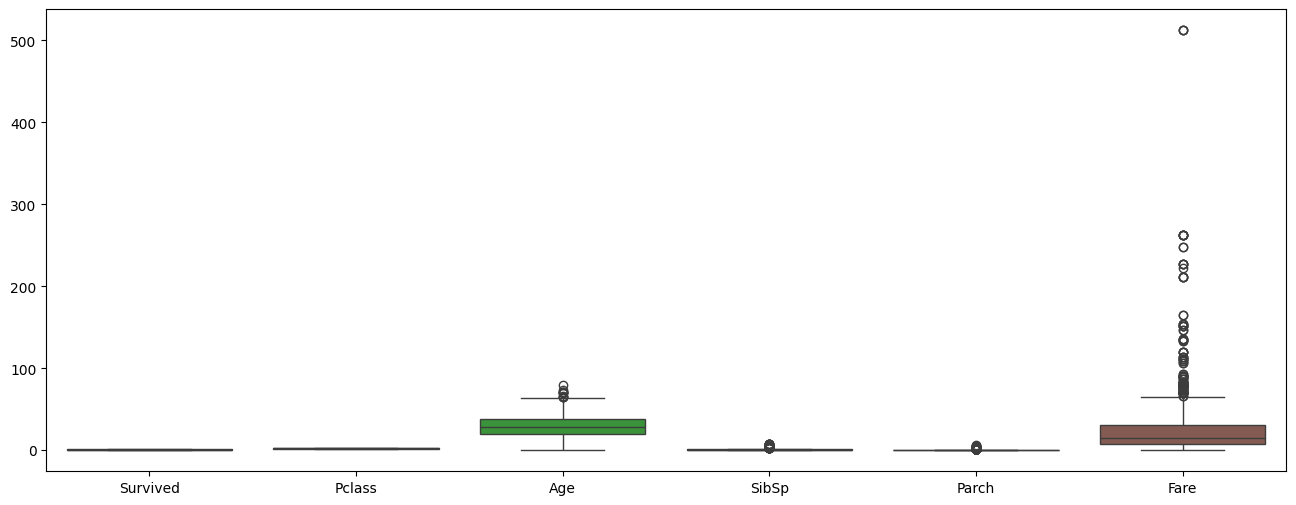

In [42]:
plt.figure(figsize=(16,6))

ax = sns.boxplot(df_titanic_train.drop(columns='PassengerId'))

### 4.9.2 - Check Normal Distribution

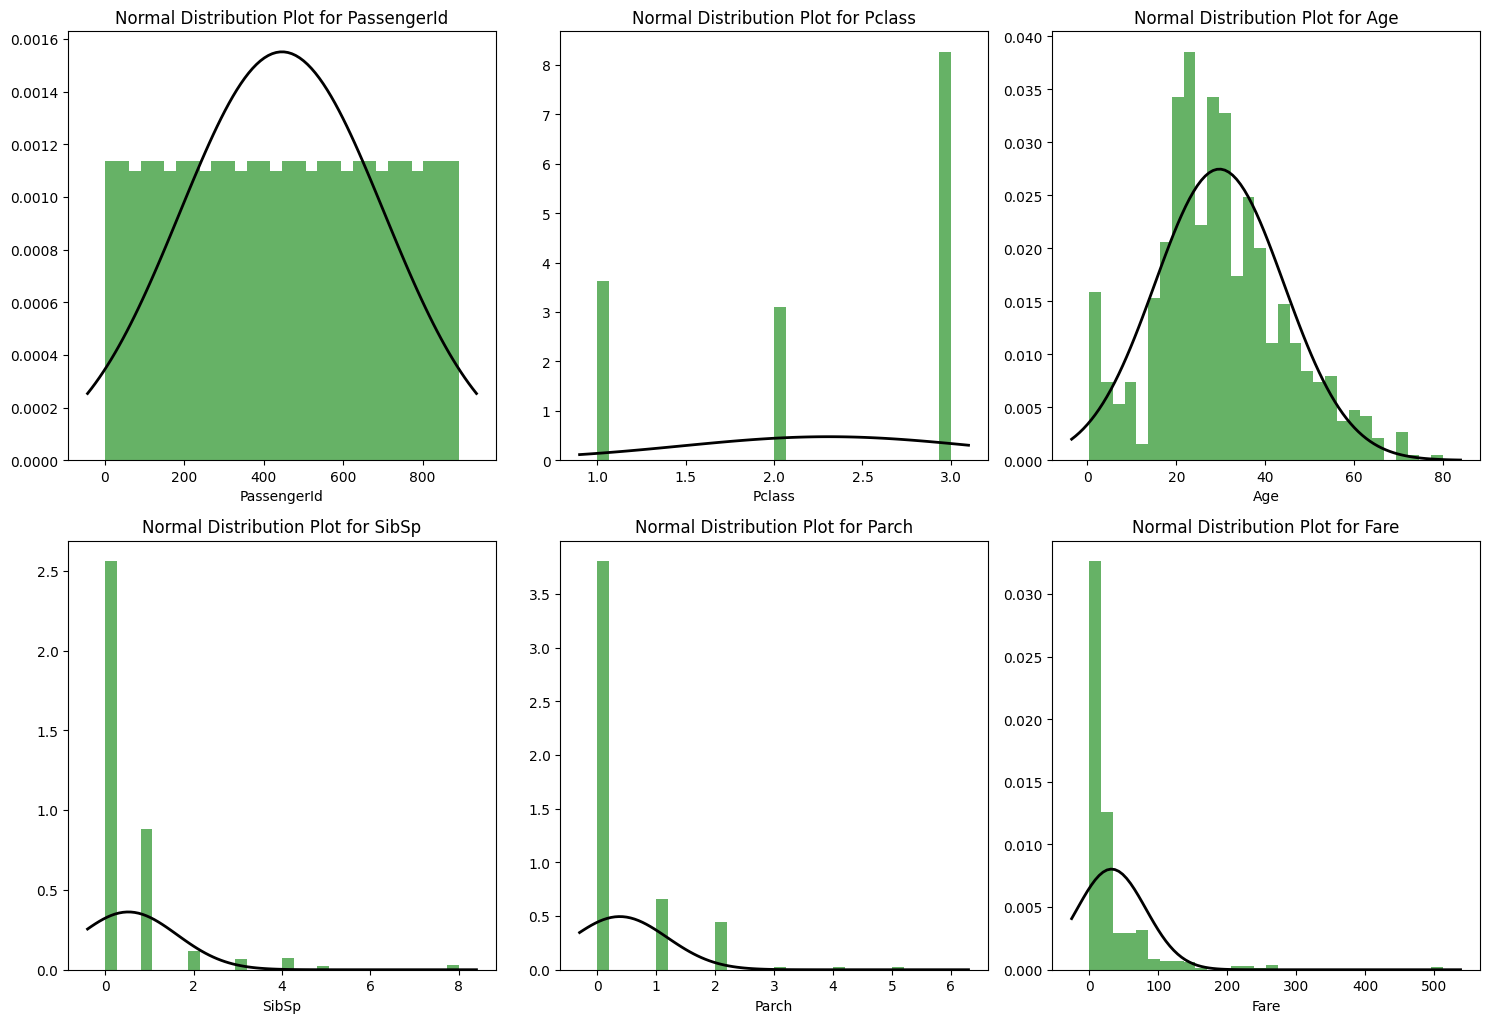

In [43]:
plot_normal_distribution_comparison(get_numerical_data(df_titanic_train), 'Survived')

## 4.10 Cheeck Correlation

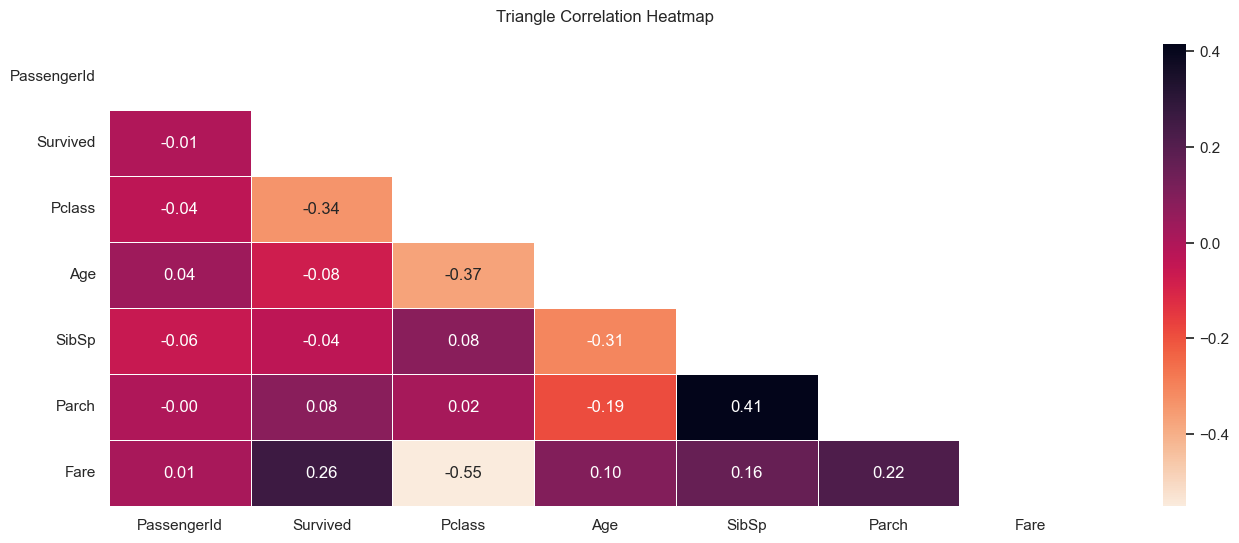

In [44]:
plot_triangle_correlation_heatmap(get_numerical_data(df_titanic_train))

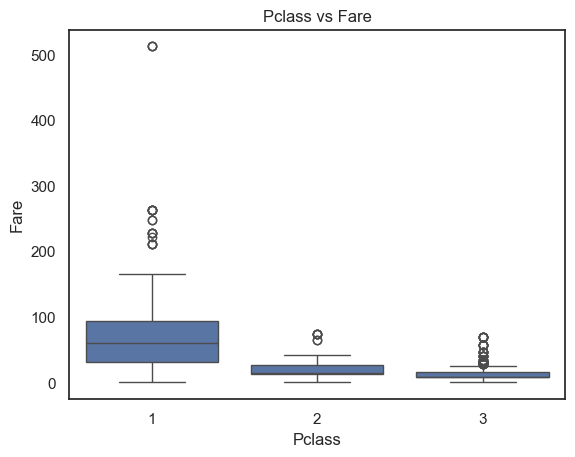

In [45]:
sns.boxplot(x='Pclass', y='Fare', data=df_titanic_train)
plt.title('Pclass vs Fare')
plt.show()


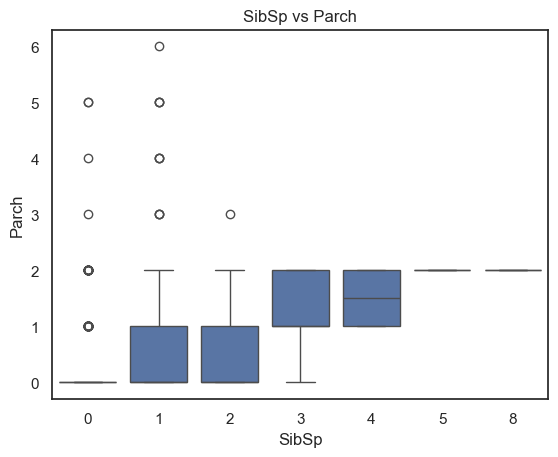

In [46]:
sns.boxplot(x='SibSp', y='Parch', data=df_titanic_train)
plt.title('SibSp vs Parch')
plt.show()


## 4.11 Check Pairplot

<Figure size 1600x600 with 0 Axes>

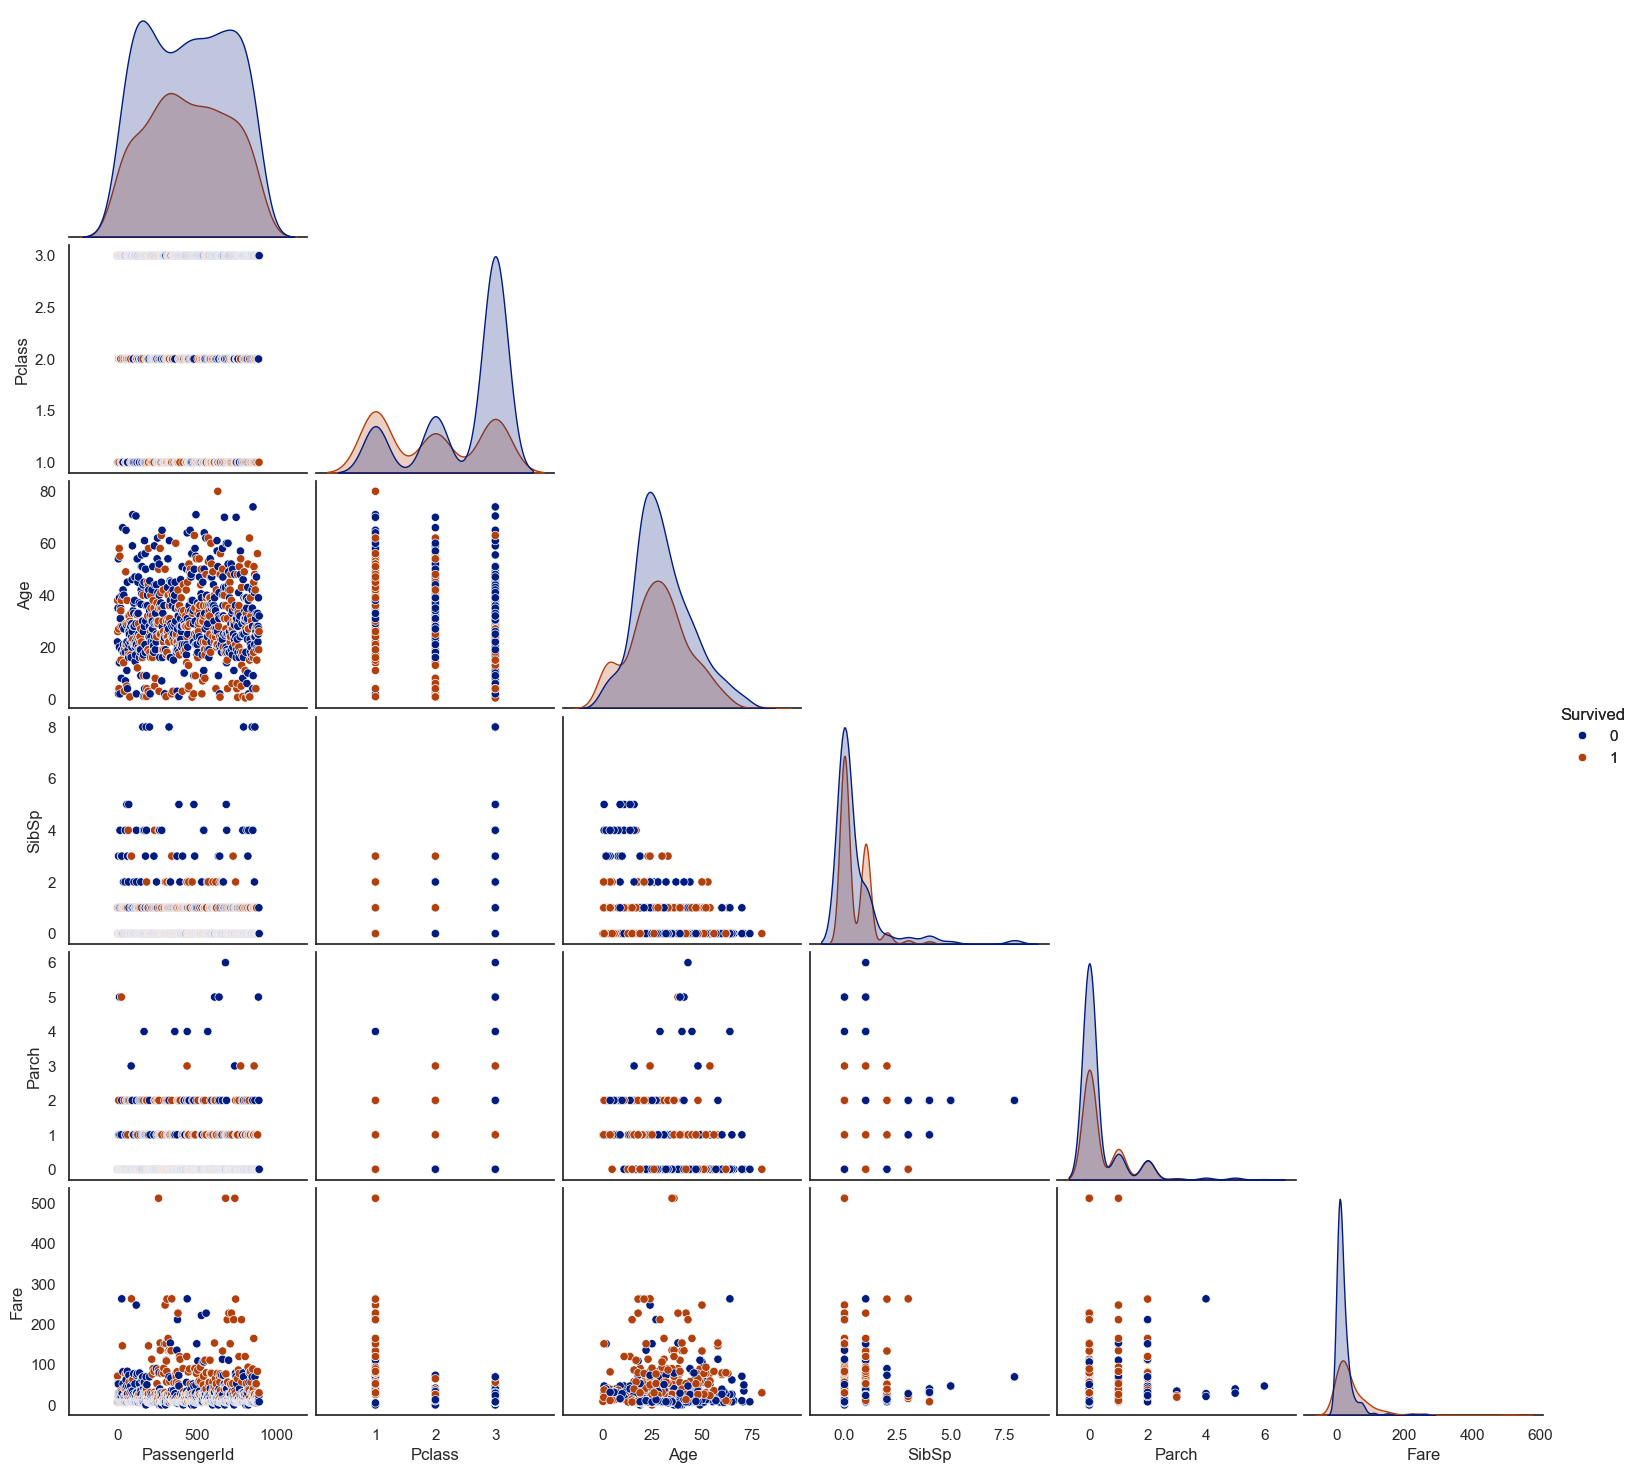

In [47]:
plot_check_pairplot(get_numerical_data(df_titanic_train), 'Survived')

## 4.12 - Check Feature Distribution by Target

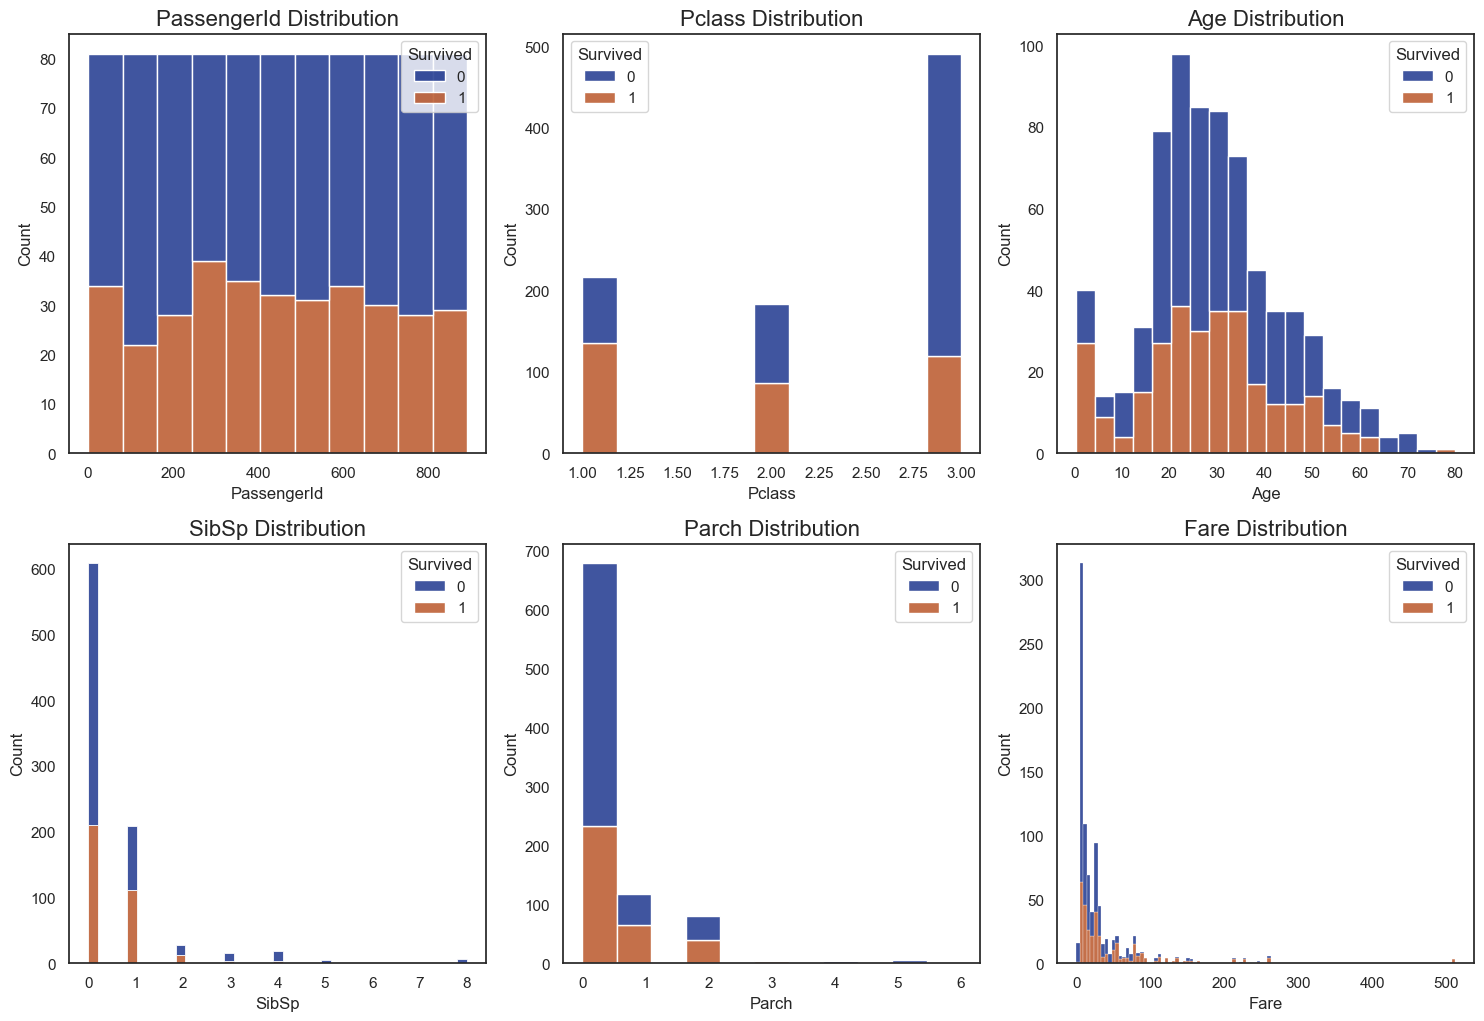

In [48]:
plot_feature_distributions_by_target(get_numerical_data(df_titanic_train), 'Survived')

## 4.13 - Outliers

### 4.13.1 - Find and Analyze

In [49]:
df_outliers, df_outliers_analyze = find_and_analyze_outliers(df_titanic_train)

In [50]:
df_outliers_analyze

,Outliers Count,Outliers Percentage
Parch,213,23.905724
Fare,116,13.019080
SibSp,46,5.162738
Age,11,1.234568


In [51]:
df_outliers

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q


### 4.13.2 - Visualization

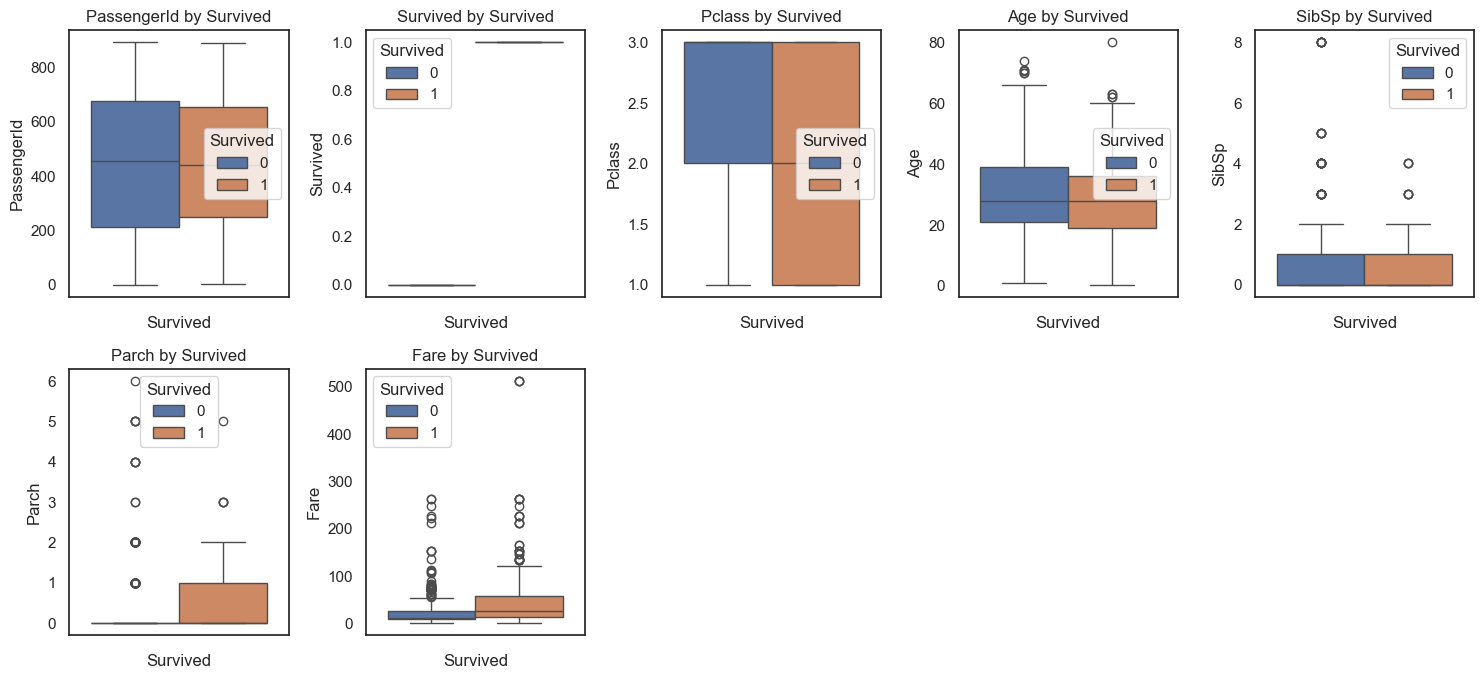

In [52]:
plot_boxplot(df_titanic_train, get_numerical_data(df_titanic_train), 'Survived')

## 4.14 - Categorical Distribution

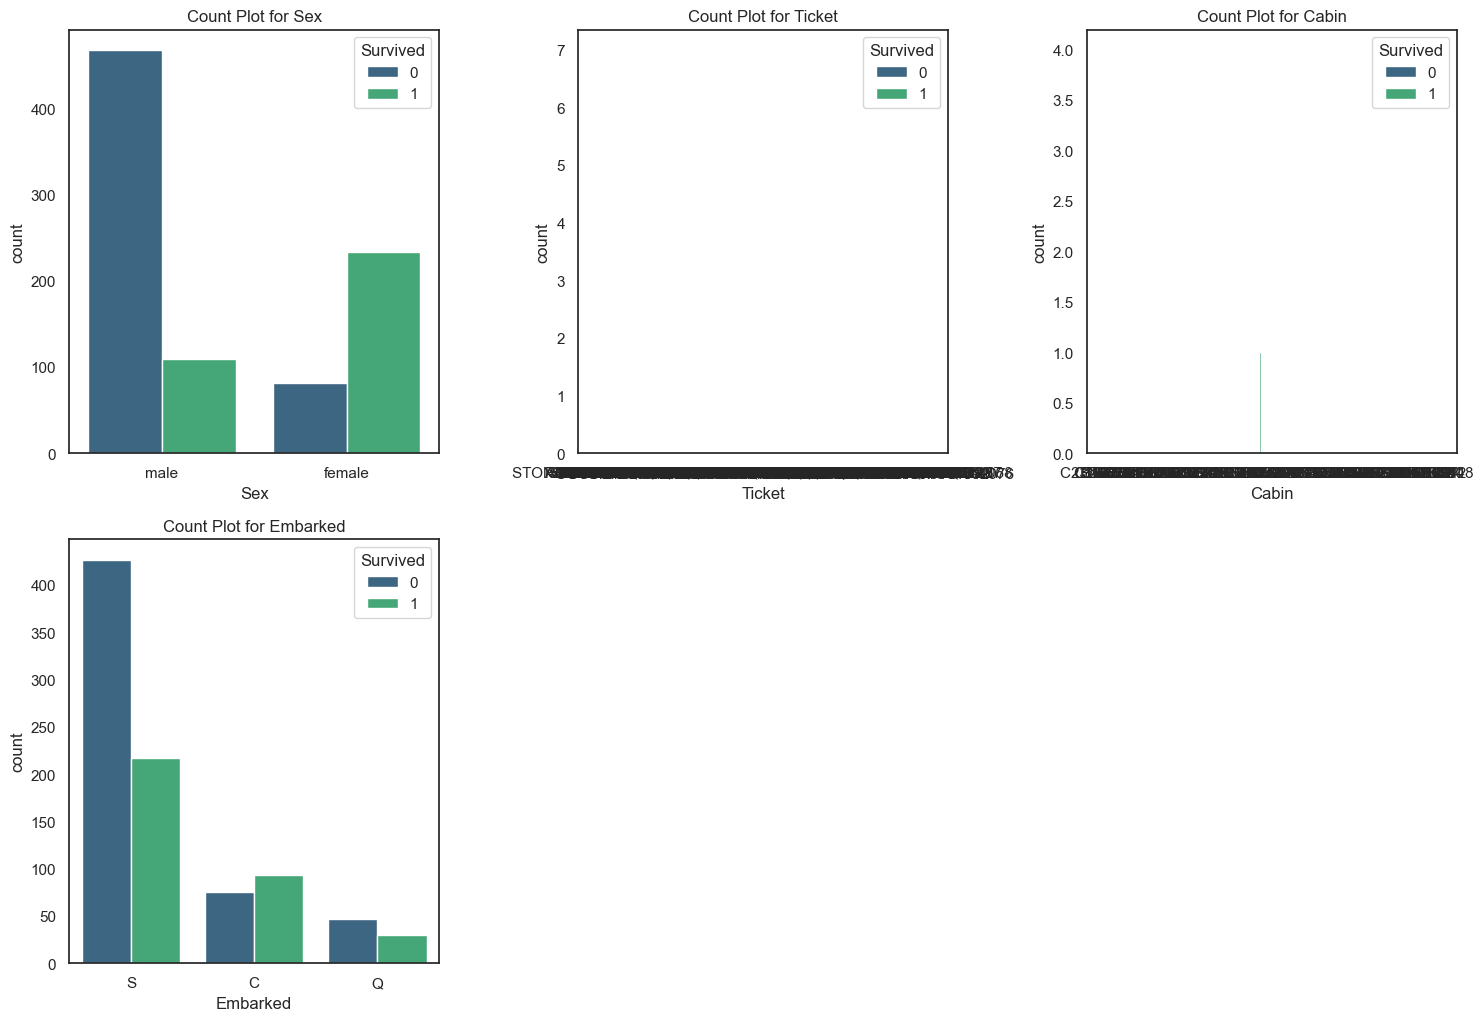

In [53]:
plot_categorical_distribution(df_titanic_train)

# 5 - INSIGHTS EDA

## 5.1 - General Train Dataset
- **Features:** 12 (including the target)
- **Labels:** 891
- **Numeric data types:** float64, int64
- **Categorical data types:** object    
- **Missing values total:** 866
- **No duplicate values**
- **Target contains 2 options:** 0, 1 (int64)

## 5.2 - Missing values
- **Age:** has 19.87% missing data that will be redefined with the median age
- **Cabin:** has 77.11% missing data, which makes it a great candidate to be removed. But this data will be grouped and transformed into numbers.
- **Embarked:** has only 0.23% missing data, which will be removed.

## 5.3 - Correlation
- The **highest correlation** in the dataset is between the features **Parch** and **Sibsp.** Both features are about family relationships, which at first glance justifies this relationship.
- The **lowest correlation** in the dataset is between the features **Pclass** and **Fare.** At first glance, it's strange to understand how passenger fare data has such a low correlation with socio-economic status.

## 5.4 - Outliers
There are outliers in **4 features** of the dataset. I usually remove them, especially when the models used are sensitive to them. The percentage of outliers per feature is:
- **Parch:** 23.91% 
- **Fare:** 13.02%
- **SibSp:** 5.16%
- **Age:** 1.23%

## 5.5 - Create Features
- **Sex:** Will be given numerical values for their respective categories
- **Cabin:** Will be given numerical values for their respective categories and be grouped by the first letter

## 5.6 - Drop Features
- **Name:** I believe that the only use here would be to take the titles and input numerical values into them
- **Ticket:** There is a high degree of variation and dispersion in this data. I don't see much use in them, maybe group them together in some way and check for some relationship with the tariff
- **Embarked:** The missing values

## 5.7 - Normalization and Standardization
- The decisive factor in rescaling the data is the **exclusive use of the KNN model.** It is extremely sensitive to **discrepant scales, outliers and prefers normalized data.**
- There is a need to rescale the data because the range of the data goes from **0 to 512.33**
- Most numerical data does not follow a normal distribution. This corroborates the fact that data must be standardized in order to bring it as close as possible to its original state.
- **But focusing on the best use of the KNN model, I will use normalization.**

# 6 - TRANSFORMATION AND CLEANING


Considering that the model used will only be the KNN, removing outliers will probably improve its performance significantly. But a good deal of information will be lost due to the percentage of outliers. 

**For this reason, I will use two datasets, one with and one without outliers, in order to compare the results.**

## 6.1 - Backup Data

In [54]:
df_transform = df_titanic_train.copy()

In [55]:
df_transform

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 6.2 - Transform Data and Normalized

In [56]:
df_titanic_transform = data_transform(df_transform.drop(columns='Survived'))

In [57]:
df_normalized = data_standarlized(df_titanic_transform)

## 6.3 - With and Without Outliers

### 6.3.1 - With Outlisers

In [58]:
df_normalized_with_outliers = df_normalized.copy()

In [59]:
df_normalized_with_outliers

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0.827377,-0.737695,-0.565736,0.432793,-0.473674,-0.502445,-0.488461,-0.568837,-0.538706
1,-1.566107,1.355574,0.663861,0.432793,-0.473674,0.786845,1.398325,1.005181,0.760311
2,0.827377,1.355574,-0.258337,-0.474545,-0.473674,-0.488854,-0.488461,-0.568837,0.110803
3,-1.566107,1.355574,0.433312,0.432793,-0.473674,0.420730,1.398325,-0.568837,0.760311
4,0.827377,-0.737695,0.433312,-0.474545,-0.473674,-0.486337,-0.488461,-0.568837,-0.538706
...,...,...,...,...,...,...,...,...,...
886,-0.369365,-0.737695,-0.181487,-0.474545,-0.473674,-0.386671,-0.488461,-0.568837,2.708836
887,-1.566107,1.355574,-0.796286,-0.474545,-0.473674,-0.044381,0.769396,-0.568837,0.110803
888,0.827377,1.355574,-0.104637,0.432793,2.008933,-0.176263,-0.488461,-0.568837,0.110803
889,-1.566107,-0.737695,-0.258337,-0.474545,-0.473674,-0.044381,1.398325,1.005181,-0.538706


### 6.3.2 - Without Outliers

In [60]:
df_normalized_without_outliers = df_normalized.drop(labels= df_outliers.index).copy()

In [61]:
df_normalized_without_outliers

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0.827377,-0.737695,-0.565736,0.432793,-0.473674,-0.502445,-0.488461,-0.568837,-0.538706
2,0.827377,1.355574,-0.258337,-0.474545,-0.473674,-0.488854,-0.488461,-0.568837,0.110803
3,-1.566107,1.355574,0.433312,0.432793,-0.473674,0.420730,1.398325,-0.568837,0.760311
4,0.827377,-0.737695,0.433312,-0.474545,-0.473674,-0.486337,-0.488461,-0.568837,-0.538706
5,0.827377,-0.737695,-0.104637,-0.474545,-0.473674,-0.478116,-0.488461,2.579199,-0.538706
...,...,...,...,...,...,...,...,...,...
884,0.827377,-0.737695,-0.335187,-0.474545,-0.473674,-0.506472,-0.488461,-0.568837,-0.538706
886,-0.369365,-0.737695,-0.181487,-0.474545,-0.473674,-0.386671,-0.488461,-0.568837,2.708836
887,-1.566107,1.355574,-0.796286,-0.474545,-0.473674,-0.044381,0.769396,-0.568837,0.110803
889,-1.566107,-0.737695,-0.258337,-0.474545,-0.473674,-0.044381,1.398325,1.005181,-0.538706


# 7 - INPUT TARGET AND SUMMARY REPORT

## 7.1 - Targets

In [62]:
target_with_outliers = df_transform['Survived']

In [63]:
target_without_outliers = df_transform['Survived'].drop(labels= df_outliers.index)

## 7.2 - Summary Report

In [64]:
summary_report = pd.DataFrame(columns=['Scale_Name', 'Dataset', 'Neighbors', 'Score', 'Precision', 'Recall', 'F1_Score'])

# 8 - EXPLORING MODEL

## 8.1 - Neighbors = 3

In [65]:
train_and_evaluate_model('With Outliers', df_normalized_with_outliers, target_with_outliers)

----------------------------------
Train Confusion Matrix
----------------------------------
Prediction    0    1  All
Real                     
0           394   26  420
1            54  194  248
All         448  220  668
----------------------------------
Train: 0.8802395209580839

----------------------------------
Test Confusion Matrix
----------------------------------
Prediction    0   1  All
Real                    
0           113  16  129
1            23  71   94
All         136  87  223
----------------------------------
Test: 0.8251121076233184



In [66]:
train_and_evaluate_model('Without Outliers', df_normalized_without_outliers, target_without_outliers)

----------------------------------
Train Confusion Matrix
----------------------------------
Prediction    0    1  All
Real                     
0           287   23  310
1            37  101  138
All         324  124  448
----------------------------------
Train: 0.8660714285714286

----------------------------------
Test Confusion Matrix
----------------------------------
Prediction    0   1  All
Real                    
0            99  11  110
1            17  23   40
All         116  34  150
----------------------------------
Test: 0.8133333333333334



## 8.2 - Neighbors = 5

In [67]:
train_and_evaluate_model('With Outliers', df_normalized_with_outliers, target_with_outliers, 5)

----------------------------------
Train Confusion Matrix
----------------------------------
Prediction    0    1  All
Real                     
0           388   32  420
1            63  185  248
All         451  217  668
----------------------------------
Train: 0.8577844311377245

----------------------------------
Test Confusion Matrix
----------------------------------
Prediction    0   1  All
Real                    
0           113  16  129
1            25  69   94
All         138  85  223
----------------------------------
Test: 0.8161434977578476



In [68]:
train_and_evaluate_model('Without Outliers', df_normalized_without_outliers, target_without_outliers, 5)

----------------------------------
Train Confusion Matrix
----------------------------------
Prediction    0    1  All
Real                     
0           284   26  310
1            42   96  138
All         326  122  448
----------------------------------
Train: 0.8482142857142857

----------------------------------
Test Confusion Matrix
----------------------------------
Prediction    0   1  All
Real                    
0            99  11  110
1            17  23   40
All         116  34  150
----------------------------------
Test: 0.8133333333333334



## 8.3 - Neighbors = 7

In [69]:
train_and_evaluate_model('With Outliers', df_normalized_with_outliers, target_with_outliers, 7)

----------------------------------
Train Confusion Matrix
----------------------------------
Prediction    0    1  All
Real                     
0           379   41  420
1            64  184  248
All         443  225  668
----------------------------------
Train: 0.842814371257485

----------------------------------
Test Confusion Matrix
----------------------------------
Prediction    0   1  All
Real                    
0           114  15  129
1            28  66   94
All         142  81  223
----------------------------------
Test: 0.8071748878923767



In [70]:
train_and_evaluate_model('Without Outliers', df_normalized_without_outliers, target_without_outliers, 7)

----------------------------------
Train Confusion Matrix
----------------------------------
Prediction    0    1  All
Real                     
0           285   25  310
1            48   90  138
All         333  115  448
----------------------------------
Train: 0.8370535714285714

----------------------------------
Test Confusion Matrix
----------------------------------
Prediction    0   1  All
Real                    
0           101   9  110
1            18  22   40
All         119  31  150
----------------------------------
Test: 0.82



## 8.4 - Neighbors = 9

In [71]:
train_and_evaluate_model('With Outliers', df_normalized_with_outliers, target_with_outliers, 9)

----------------------------------
Train Confusion Matrix
----------------------------------
Prediction    0    1  All
Real                     
0           383   37  420
1            71  177  248
All         454  214  668
----------------------------------
Train: 0.8383233532934131

----------------------------------
Test Confusion Matrix
----------------------------------
Prediction    0   1  All
Real                    
0           115  14  129
1            28  66   94
All         143  80  223
----------------------------------
Test: 0.8116591928251121



In [72]:
train_and_evaluate_model('Without Outliers', df_normalized_without_outliers, target_without_outliers, 9)

----------------------------------
Train Confusion Matrix
----------------------------------
Prediction    0    1  All
Real                     
0           284   26  310
1            51   87  138
All         335  113  448
----------------------------------
Train: 0.828125

----------------------------------
Test Confusion Matrix
----------------------------------
Prediction    0   1  All
Real                    
0           101   9  110
1            20  20   40
All         121  29  150
----------------------------------
Test: 0.8066666666666666



## 8.5 - Model Scores

In [73]:
summary_report

,Scale_Name,Dataset,Neighbors,Score,Precision,Recall,F1_Score
0,With Outliers,Train,3,0.880240,0.880338,0.880240,0.878589
1,With Outliers,Test,3,0.825112,0.824648,0.825112,0.824040
2,Without Outliers,Train,3,0.866071,0.863844,0.866071,0.863972
3,Without Outliers,Test,3,0.813333,0.806254,0.813333,0.808244
4,With Outliers,Train,5,0.857784,0.857424,0.857784,0.855575
5,With Outliers,Test,5,0.816143,0.815858,0.816143,0.814620
6,Without Outliers,Train,5,0.848214,0.845204,0.848214,0.845453
7,Without Outliers,Test,5,0.813333,0.806254,0.813333,0.808244
8,With Outliers,Train,7,0.842814,0.841515,0.842814,0.841087
9,With Outliers,Test,7,0.807175,0.807874,0.807175,0.804638


In [74]:
datasets = summary_report['Scale_Name'].unique()

with_outliers_scores = summary_report[summary_report['Scale_Name'] == datasets[0]].sort_values('Dataset')
without_outliers_scores = summary_report[summary_report['Scale_Name'] == datasets[1]].sort_values('Dataset')

In [75]:
with_outliers_scores

,Scale_Name,Dataset,Neighbors,Score,Precision,Recall,F1_Score
1,With Outliers,Test,3,0.825112,0.824648,0.825112,0.824040
5,With Outliers,Test,5,0.816143,0.815858,0.816143,0.814620
9,With Outliers,Test,7,0.807175,0.807874,0.807175,0.804638
13,With Outliers,Test,9,0.811659,0.812965,0.811659,0.808929
0,With Outliers,Train,3,0.880240,0.880338,0.880240,0.878589
4,With Outliers,Train,5,0.857784,0.857424,0.857784,0.855575
8,With Outliers,Train,7,0.842814,0.841515,0.842814,0.841087
12,With Outliers,Train,9,0.838323,0.837483,0.838323,0.835519


In [76]:
without_outliers_scores

,Scale_Name,Dataset,Neighbors,Score,Precision,Recall,F1_Score
3,Without Outliers,Test,3,0.813333,0.806254,0.813333,0.808244
7,Without Outliers,Test,5,0.813333,0.806254,0.813333,0.808244
11,Without Outliers,Test,7,0.820000,0.811656,0.820000,0.812129
15,Without Outliers,Test,9,0.806667,0.796029,0.806667,0.795859
2,Without Outliers,Train,3,0.866071,0.863844,0.866071,0.863972
6,Without Outliers,Train,5,0.848214,0.845204,0.848214,0.845453
10,Without Outliers,Train,7,0.837054,0.833293,0.837054,0.832561
14,Without Outliers,Train,9,0.828125,0.823781,0.828125,0.822896


# 9 - INSIGHTS MODEL EXPLORATION

## 9.1 - With Outliers Dataset
- The model performances on the test dataset seem to decrease slightly as the number of neighbors increases.
- The F1 Score, which balances precision and recall, ranges from 0.775453 to 0.796534.
- On the training dataset, the scores are higher, indicating potential overfitting, especially with a smaller number of neighbors.

## 9.2 - Without Outliers Dataset
- The model performances on the test dataset are generally better compared to the dataset with outliers.
- The F1 Score ranges from 0.816000 to 0.821941, indicating better balance between precision and recall.
- On the training dataset, the scores are still relatively high, suggesting good performance, and they are closer to the test scores compared to the dataset with outliers.

## 9.3 - Neighbor Selection
- It seems that using 5 neighbors gives good results for both datasets (e.g., 0.789238 to 0.826667 for the test dataset).
- Selecting an appropriate number of neighbors is crucial; too few neighbors might lead to overfitting, while too many might result in underfitting.

## 9.4 - Effect of Outliers
- The comparison between the results with and without outliers suggests that removing outliers improves the model performance, particularly in terms of F1 Score.

# 10 - MODEL OPTIMIZATION

## 10.1 - Without Outliers Model Optimization

In [77]:
n_neighbors = [3,5,7,9]
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree','kd_tree']
p = [1,2]

classifier_performance(df_normalized_without_outliers, target_without_outliers, n_neighbors, weights, algorithm, p)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
----------------------------------------------------------------------------------------------------
KNN
----------------------------------------------------------------------------------------------------
Best Score: 80.77
Best Parameters:
 Algorithm = auto
 N_neighbors = 9
 p = 1
 Weights = uniform
----------------------------------------------------------------------------------------------------


In [78]:
n_neighbors = 9
weights = 'uniform'
algorithm = 'auto'
p = 1
cross_validation_score(df_normalized_with_outliers, target_with_outliers, n_neighbors, weights, algorithm, p)

Cross Validation Scores: [0.81564246 0.80337079 0.83707865 0.80337079 0.85955056]
Cross Validation Mean: 82.38


In [83]:
without_outliers_scores.query('Neighbors == 9')

,Scale_Name,Dataset,Neighbors,Score,Precision,Recall,F1_Score
15,Without Outliers,Test,9,0.806667,0.796029,0.806667,0.795859
14,Without Outliers,Train,9,0.828125,0.823781,0.828125,0.822896


# 11 - SUBMISSION

## 11.1 - Without Submiison CSV

In [80]:
df_test  = data_standarlized(data_transform(df_titanic_test.copy()))

In [81]:
knn = KNeighborsClassifier(n_neighbors = 9, weights = 'uniform', algorithm = 'auto', p = 1)
knn.fit(df_normalized_without_outliers, target_without_outliers)
Y_pred = knn.predict(df_test)
acc_knn = round(knn.score(df_normalized_without_outliers, target_without_outliers) * 100, 2)
acc_knn

83.78

In [82]:
submission_df = pd.DataFrame({
    'PassengerId': df_titanic_test["PassengerId"],
    'Survived': Y_pred
})

# submission_df.to_csv(f'submission_v{2}.csv', index=False)

# 12 - Conclusion

## 12.1 - Submissions General Report

|Submissions|Kaggle Submissions Score|Top Percentage|Position         |Model Score|Train Score|Train Precision|Train Recall|Train F1  |
|-----------|------------------------|--------------|-----------------|-----------|-----------|---------------|------------|----------|
|1st        |0.74401                 |Top 90%       |13768 of 15337   |84.11%     |85.04%     |84.75%         |85.05%      |84.71%    |
|2nd        |0.76076                 |Top 83%       |12639 of 15337   |85.12%     |84.82%     |84.51%         |84.82%      |84.47%    |